# Binary Spiking Neural Network
### Daniel Maidment
### 2019/11/06

$\renewcommand{\vec}{\mathbf}$
$\newcommand{\x}{\vec{x}}$
$\newcommand{\s}{\vec{s}}$
$\renewcommand{\phi}{\varphi}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\y}{\vec{y}}$
$\renewcommand{\v}{\vec{v}}$
$\newcommand{\I}{\vec{I}}$
$\newcommand{\z}{\vec{z}}$
$\newcommand{\a}{\vec{a}}$
$\newcommand{\b}{\vec{b}}$
$\newcommand{\t}{\vec{t}}$
$\newcommand{\W}{\vec{W}}$
$\newcommand{\w}{\;\!}$
$\newcommand{\th}{\text{th}}$
$\newcommand{\(}{\left (}$
$\newcommand{\)}{\right )}$

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from IPython.display import IFrame

## Feed Forward Neural networks
\cite{goodfellow_deep_2016}. 

In [103]:
IFrame("images/feed_forward_neural_net_weights.svg", width=450, height=250)

\begin{equation}
    \z^{(1)} = \W^{(0)}\cdot{\x}
\end{equation}

\begin{equation}
    \a^{(1)} = f\left(\z^{(1)}\right)
\end{equation}

\begin{equation}
    \z^{(2)} = \W^{(1)}\cdot{\a^{(1)}}
\end{equation}

\begin{equation}
    \a^{(2)} = f\left(\z^{(2)}\right)
\end{equation}

\begin{equation}
    \y = \W^{(2)}\cdot{\a^{(2)}}
\end{equation}

### Common activation functions

#### Sigmoid
\begin{equation}
        f({x}) =\frac{1}{1+e^{-{x}}},
\end{equation}

#### Hyperbolic tangent function
\begin{equation}
    f({x}) =\tanh{({x})},
\end{equation}

#### Rectified linear unit function (ReLU):
\begin{equation}
    ReLU({x}) = \left\{
            \begin{array}{ll}
                0 & \quad {x} < 0 \\
                {x} & \quad {x} \geq 0
            \end{array}
        \right.
\end{equation}

The activation function serves the purpose of forcing the successive layers of the neural network to be linearly independent (the successive weight matrices do not combine into one matrix).
From a computational perspective, these operations are heavy with multiplications. 

### Common activation functions

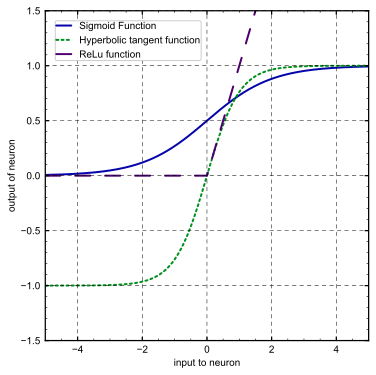

In [87]:
import numpy as np
import spyder_utilities as su
x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = su.config_axis(ax, x_lim=(-5, 5), y_lim=(-1.5, 1.5), Eng=False)
ax.plot(x, 1/(1+np.e**(-x)), linewidth=2, label="Sigmoid Function")
ax.plot(x, np.tanh(x), linestyle=':', linewidth=2, label="Hyperbolic tangent function")
ax.plot(x, np.maximum(0, x), linestyle='--', linewidth=2, label="ReLu function")
ax.set_xlabel("input to neuron")
ax.set_ylabel("output of neuron")
ax.legend()
plt.show()

## Complexity

* The complexity of a square $\left[n\times n\right]$ matrix multiplied by a $\left[n\times 1\right]$ matrix is given by $O(n^2)$ \cite{cormen_introduction_2009} 

Where a multiplication operation is assumed to have a complexity of $O(1)$. 

Each hidden layer has at least an matrix operation of this kind. 

* The activation function's complexity is at least proportional to $O(\log{(n)})$. 

* Hence, for every layer of the network $l$ (except the input layer), there is at least a matrix multiplication and at least an activation. 

* If a given layer has 10 neurons, then the matrix operation has complexity of at least $O(100)$, while a layer of size 100 has complexity of at least $O(10\,000)$. 

Given that a typical CPU can run as many floating point operations in parallel as there are cores, a multi-cored system can reduce the effective run time as a factor of the number of cores. For instance, the 8$^{th}$ generation Intel\textregistered Core\texttrademark i7 Processor \cite{noauthor_intel_2018} has six cores. Six cores means a maximum of six multiplication operations for any given cycle which implies a reduced run-time by a factor of 6 at most. Use of all the cores would also leave the processor unavailable for other tasks. From this it can be seen that large ANNs can very quickly require large amounts of computational power; since any given forward pass of the NN requires each computation to be made again.

## FPGAs

### Configurable Logic Block

In [71]:
IFrame("images/FPGA_CLB.svg", width=450, height=250)

FPGAs allow for hardware level implementation of computational structures. FPGAs are generally made up of configurable logic blocks (CLBs); whose connections are configurable. The LE elements frequently consist of one or more look-up tables (LUTs), storage elements, carry logic, and multiplexers. These components allow the CLBs to simulate various logical operations from simple Boolean logic, to addition, to multiplication. 

### Congifurable Logic Block Matrix

In [73]:
IFrame("images/CLB_matrix.svg", width=600, height=600)

The logic elements are also networked  together by means of configurable buses in such away that logic elements across the length of the FPGA can be connected to carry out logical operations. These configurable elements allow for complex computational architectures to be implemented on the FPGA; from arithmetic logic units (ALUs) to digital signal processing (DSP) functions like digital filters and fast Fourier transforms (FFTs). Implementation of these architectures can serve any number of purposes, from rapid prototyping of computational architectures, to offloading necessary but repetitive computations from a microprocessor or CPU.

The modularity of FPGAs CLBs, coupled with the configurable data bus system allows for repeated parallel structures. This lends itself well to implementing processors that are required to execute many similar operations in parallel rapidly, such as FFTs or digital filters. To that end FPGA manufacturers have been loading FPGAs with less configurable more dedicated hardware such as pre-optimised multiply-accumulators (MACs) known as DSP slices \cite{frank_artificial_1995, wolff_parspike-parallel_1999, wang_enhanced_2017, govindu_analysis_2004}. DSP slices are in high-demand in these multiplication heavy computations. 

Given how well FPGAs seem to lend themselves to parallelism and modularity, it seems reasonable to assume that NNs could take advantage of this without the need for dedicated resources that could otherwise be used for other DSP applications.

## The binary spiking neural network

### Synapse

In [104]:
IFrame("images/cyclic_synapse.svg", width=800, height=300)

Synapses are implemented as cyclic shift registers, where the output of the shift register feeds the input. The output of the shift register acts as an input to a binary two-input AND operator. The second input is the output of the presynaptic neuron, and the output of the AND operator is an input to a postsynaptic neuron. The function of the synapse is to regulate the firing rate of the presynaptic neuron, and the accumulation rate -and hence the firing rate- of the post-synaptic neuron. 

Each element of the shift register is initially seeded with a binary value that has some probability $p$ of being a 1, and is otherwise a 0.

\begin{equation}
    P(x) = 
    \begin{cases}
        p, &x=1,
        \\
        1-p, &x=0.
    \end{cases}
\end{equation}
The elements are independently seeded.

The guiding principle and intuition behind the synaptic implementation is that the synapse regulates the firing rate of the presynaptic neuron by modulating the probability of each spike reaching the post synaptic neuron. The result is that if the presynaptic neuron fires with frequency $f_{\text{pre}}$ and the synapse is seeded with some probability $p_{\text{synapse}}$ then the apparent firing rate at the postsynaptic neuron

\begin{equation}
    f_{\text{apparent}} = p_{\text{synapse}}\cdot f_{\text{pre}} \label{eq:f_ideal}
\end{equation}
As $N\to \infty$.

### Neurons

In [85]:
IFrame("images/Accumulator_Neuron_Input.png", width=400, height=175)

#### Input Neuron

The input neuron is fundamentally different from the remaining neurons in the network. The premise of the binary spiking neural network is that it reduces the complexity of the basic operations of a standard feed-forward neural network. The matrix multiplications of the standard FFNN are reduced to simultaneous binary AND operations across the network that execute in a single clock cycle. However, this construction requires a conversion of real world input parameters (typically some decimal value) into binary. The chosen method of conversion requires normalising the input value to some $p$ where

\begin{equation}
    P(x) = 
    \begin{cases}
        p, &x=1,
        \\
        1-p, &x=0.
    \end{cases}
\end{equation}

\begin{equation}
    p \in (0, 1).
\end{equation}

This operation for a given input value occurs for some number of clock cycles N.

It follows that for some number of network layers L, the minimum time required for the network to process some input is approximately
\begin{equation}
    \frac{N+L}{f_{\text{ck}}}.
\end{equation}

It also follows that if the output $x$ is an independent sample of a Bernoulli process with probability $p$ then
\begin{equation}
    E(x) \to p \text{ as } N \to \infty.
\end{equation}

In [80]:
IFrame("images/Accumulator_Neuron_General.svg", width=800, height=225)

#### Hidden layer neuron

In [86]:
IFrame("images/BSNN_FBD.svg", width=1600, height=550)

### Binary spiking neural network

## Results

In [93]:
"""
Daniel Maidment

Thu Oct 15 2019
"""
########################################################################
import spyder_utilities as su
import numpy as np
import matplotlib.pyplot as plt
from spnetwork.synapse import Synapse
########################################################################
np.random.seed(100)

### Synapse

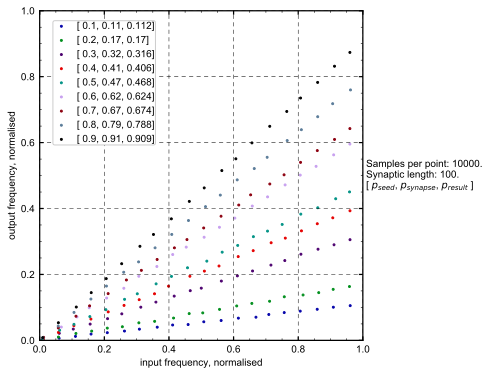

In [98]:
size = 10000
N = 100

fig2, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = su.config_axis(ax, x_lim=(0, 1), y_lim=(0, 1), Eng=False)
P = np.arange(0.01, 1, 0.05)

for p in np.arange(0.1, 1, 0.1):
    testSynapse = Synapse(N=N, p=p)
    p_x = np.empty(np.shape(P), dtype=float)
    p_y = np.empty(np.shape(P), dtype=float)

    for i in range(len(P)):
        in_ar = np.array(np.random.binomial(1, P[i], size), dtype=bool)
        out_ar = np.zeros(size, bool)

        for j in range(size):
            out_ar[j] = testSynapse*in_ar[j]

        p_x[i] = np.mean(in_ar)
        p_y[i] = np.mean(out_ar)

    slope = np.mean(np.gradient(p_y, p_x))
    label = "[{:4.3}, {:4.3}, {:4.3}]".format(p, testSynapse.getMean(), slope)
    ax.scatter(p_x, p_y, label=label)

s = f"Samples per point: {size}."
s += f"\nSynaptic length: {N}.\n"
s += r"[ $p_{seed}$, $p_{synapse}$, $p_{result}$ ]"
plt.legend(bbox_to_anchor=(0.01, 1), loc = "upper left")
ax.text(1.01, 0.5, s,
                  horizontalalignment='left',
                  verticalalignment='center',
                  transform=ax.transAxes)
ax.set_xlabel("input frequency, normalised")
ax.set_ylabel("output frequency, normalised")
plt.show()

#### Changing the synaptic seed frequency [$p_{seed}$] and input frequency for a fixed synaptic length [N]

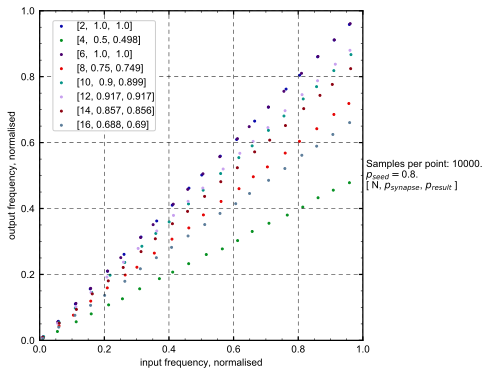

In [99]:
size = 10000
N = 17
p=0.8

fig2, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = su.config_axis(ax, x_lim=(0, 1), y_lim=(0, 1), Eng=False)
P = np.arange(0.01, 1, 0.05)
for n in np.arange(2, N, 2):
    testSynapse = Synapse(N=n, p=p)
    p_x = np.empty(np.shape(P), dtype=float)
    p_y = np.empty(np.shape(P), dtype=float)

    for i in range(len(P)):
        in_ar = np.array(np.random.binomial(1, P[i], size), dtype=bool)
        out_ar = np.zeros(size, bool)

        for j in range(size):
            out_ar[j] = testSynapse*in_ar[j]

        p_x[i] = np.mean(in_ar)
        p_y[i] = np.mean(out_ar)

    slope = np.mean(np.gradient(p_y, p_x))
    label = "[{}, {:4.3}, {:4.3}]".format(n, testSynapse.getMean(), slope)
    ax.scatter(p_x, p_y, label=label)

s = f"Samples per point: {size}.\n"
s += r"$p_{seed}=$"+f"{p}.\n"
s += r"[ N, $p_{synapse}$, $p_{result}$ ]"
plt.legend(bbox_to_anchor=(0.01, 1), loc = "upper left")
ax.text(1.01, 0.5, s,
                  horizontalalignment='left',
                  verticalalignment='center',
                  transform=ax.transAxes)
ax.set_xlabel("input frequency, normalised")
ax.set_ylabel("output frequency, normalised")
plt.show()

#### Changing the input frequency and synaptic length [N] for a fixed synaptic frequency [$p_{seed}=0.5$].

### Neurons

In [100]:
"""
Daniel Maidment

Thu Oct 15 2019
"""
########################################################################
import spyder_utilities as su
import numpy as np
import matplotlib.pyplot as plt
from spnetwork.neuron import Neuron
########################################################################
np.random.seed(100)

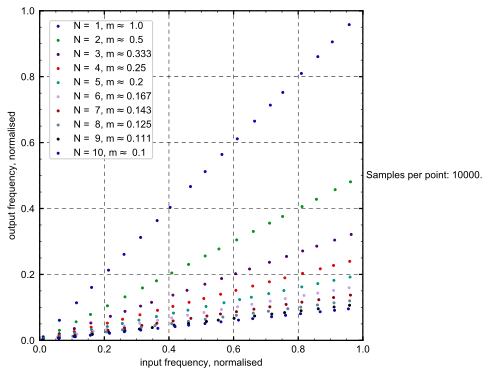

In [101]:
size = 10000
N = 11

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = su.config_axis(ax, x_lim=(0, 1), y_lim=(0, 1), Eng=False)
P = np.arange(0.01, 1, 0.05)



for n in np.arange(1, N, 1):
    tNeuron = Neuron(n)
    p_x = np.empty(np.shape(P), dtype=float)
    p_y = np.empty(np.shape(P), dtype=float)

    for i in range(len(P)):
        in_ar_1 = np.array(np.random.binomial(1, P[i], size), dtype=bool)
        p_x[i] = np.mean(in_ar_1)

        out_ar = np.zeros(size, bool)

        for j in range(size):
            out_ar[j] = tNeuron + in_ar_1[j]

        p_y[i] = np.mean(out_ar)
        tNeuron.reset()

    slope = np.mean(np.gradient(p_y, p_x))
    label = f"N = {n:2d}, m"
    label += r"$\approx$" + "{:4.3}".format(slope)
    ax.scatter(p_x, p_y, label=label)

s = f"Samples per point: {size}."
plt.legend()
ax.text(1.01, 0.5, s,
                  horizontalalignment='left',
                  verticalalignment='center',
                  transform=ax.transAxes)
ax.set_xlabel("input frequency, normalised")
ax.set_ylabel("output frequency, normalised")
plt.show()

#### Changing the input frequency and neuron length [N].